In [2]:
from load_data import  sim_arr

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split


# Split the data into train, test and validation sets
train_set, test_set = train_test_split(sim_arr, test_size=0.2, random_state=42)
train_set, valid_set = train_test_split(
    train_set, test_size=0.2, random_state=42)

print("Train set size: ", len(train_set),
      " Test set size: ", len(test_set),
      " Validation set size: ", len(valid_set))

Train set size:  1926  Test set size:  602  Validation set size:  482


In [4]:
# check gpu
import tensorflow as tf
import os


print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))

os.environ['XLA_FLAGS'] = './cuda_sdk_lib/'

2024-04-04 12:55:55.104501: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 12:55:56.188556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2024-04-04 12:55:56.958652: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 12:55:57.332659: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 12:55:57.332979: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
import optuna

from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError

# get input shape from the data
input_shape = train_set.shape[1:]
output_shape = (1, 1, 3)


def create_model(trial):
    # Hyperparameters to optimize
    num_layers = trial.suggest_int('num_layers', 1, 4)

    filters = [trial.suggest_int(f'filters_{i}', 1, 12)
               for i in range(num_layers -1)] + [output_shape[-1]]

    activation = [trial.suggest_categorical(
        f'activation_{i}', ['relu', 'selu', 'tanh', 'sigmoid']) for i in range(num_layers)]
    
    initializer = [trial.suggest_categorical(
        f'initializer_{i}', ['lecun_normal', 'he_normal', 'he_uniform', 'glorot_normal', 'glorot_uniform']) for i in range(num_layers)]

    kernel_sizes = [trial.suggest_int(
        f'kernel_size{i}', 2, 24) for i in range(num_layers)]

    poolsize = [[16],
                [4, 4],
                [2, 2, 4],
                [2, 2, 2, 2]]

    # Encoder
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer(input_shape=input_shape))
    for i in range(num_layers):
        encoder.add(MaxPool2D(poolsize[num_layers - 1][i]))
        encoder.add(Conv2D(
            filters[i],
            kernel_sizes[i],
            strides=1,
            activation=activation[i],
            padding='same',
            kernel_initializer=initializer[i]
        ))
    encoder.add(MaxPool2D(5))

    # Decoder
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer(input_shape=encoder.output_shape[1:]))
    for i in range(num_layers - 1, -1, -1):
        decoder.add(Conv2DTranspose(
            filters[i],
            kernel_sizes[i],
            strides=poolsize[num_layers - 1][i],
            activation=activation[i],
            padding='same',
            kernel_initializer=initializer[i]
        ))
    decoder.add(Conv2DTranspose(
        input_shape[-1],
        kernel_sizes[0],
        strides=5,
        activation=activation[0],
        padding='same',
        kernel_initializer=initializer[0]
    ))

    # Compile the model
    auto_encoder = Sequential([encoder, decoder], name="autoencoder")
    auto_encoder.compile(optimizer='adam', loss="MSE")

    return auto_encoder


def objective(trial):
    # Clear clutter from previous sessions
    tf.keras.backend.clear_session()

    # Create model
    model = create_model(trial)

    # Train the model
    history = model.fit(train_set, train_set, epochs=10, batch_size=16,
                        validation_data=(valid_set, valid_set), verbose=0)

    return history.history['val_loss'][-1]


# Perform hyperparameter optimization
study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.HyperbandPruner(),
                            study_name='autoencoder_3d',
                            storage='sqlite:///test.db',
                            load_if_exists=True)
study.optimize(objective, n_trials=0)


# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best value:", study.best_value)

[I 2024-04-04 12:55:57,965] Using an existing study with name 'autoencoder_3d' instead of creating a new one.


Best hyperparameters: {'num_layers': 4, 'filters_0': 11, 'filters_1': 10, 'filters_2': 6, 'activation_0': 'selu', 'activation_1': 'selu', 'activation_2': 'relu', 'activation_3': 'selu', 'initializer_0': 'he_normal', 'initializer_1': 'glorot_normal', 'initializer_2': 'glorot_uniform', 'initializer_3': 'he_uniform', 'kernel_size0': 24, 'kernel_size1': 2, 'kernel_size2': 7, 'kernel_size3': 15}
Best value: 0.0040472508408129215


In [6]:
# Train the model with the best hyperparameters
auto_encoder = create_model(study.best_trial)
history = auto_encoder.fit(train_set, train_set, epochs=10, batch_size=32,
                           validation_data=(valid_set, valid_set))

auto_encoder.evaluate(test_set, test_set)

/home/tux/optim/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2024-04-04 12:55:58.019065: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 12:55:58.019508: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 12:55:58.019844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative val

Epoch 1/10


I0000 00:00:1712228160.247292    3943 service.cc:145] XLA service 0x591e5c3d7d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712228160.247332    3943 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 SUPER, Compute Capability 7.5
2024-04-04 12:56:00.366014: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-04 12:56:00.640723: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-04-04 12:56:01.814992: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-04 12:56:03.932290: W external/local_xla/xla/service/gpu/llvm_gpu_backend

 3/61 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.2615

I0000 00:00:1712228165.136701    3943 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1705

2024-04-04 12:56:09.097710: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1696

2024-04-04 12:56:13.169842: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - loss: 0.1687 - val_loss: 0.0553
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0491 - val_loss: 0.0310
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0299 - val_loss: 0.0194
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0209 - val_loss: 0.0150
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0162 - val_loss: 0.0119
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0124 - val_loss: 0.0098
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0110 - val_loss: 0.0086
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0086 - val_loss: 0.0076
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0075 - val_loss: 0.0064
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0076

2024-04-04 12:56:53.562216: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0075


0.007482052780687809

In [13]:
# summarize the encoder and decoder architecture
auto_encoder.get_layer('encoder').summary()
auto_encoder.get_layer('decoder').summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 40, 40, 11)     │        19,019 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 11)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 10)     │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 6)      │         2,946 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 6)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 3)        │         4,053 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 3)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,468 (103.39 KB)

 Trainable params: 26,468 (103.39 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (None, 2, 2, 3)        │         2,028 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 4, 4, 6)        │           888 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 8, 8, 10)       │           250 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 11)     │        63,371 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 80, 80, 3)      │        19,011 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,548 (334.17 KB)

 Trainable params: 85,548 (334.17 KB)

 Non-trainable params: 0 (0.00 B)

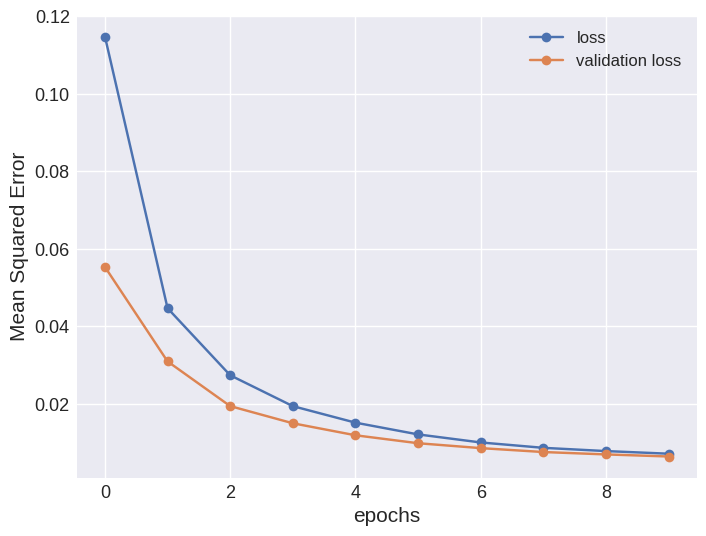

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], "-o", label="loss")
plt.plot(history.history["val_loss"], "-o", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid()
plt.show()

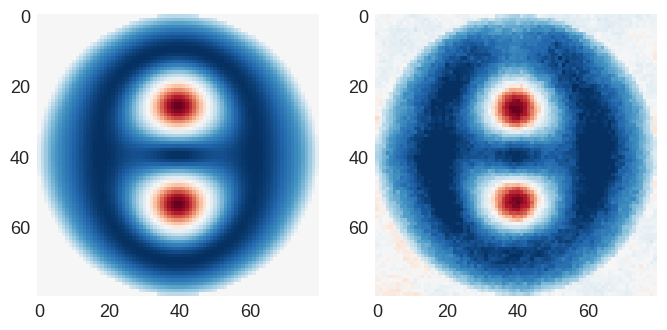

In [30]:
i = np.random.randint(0, len(test_set))
in_sim = test_set[i: i + 1]
out_sim = auto_encoder(in_sim)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(in_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")
ax[1].imshow(out_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")

In [31]:
from tensorflow.keras.layers import Flatten as Flatten

feature_extractor = Sequential(
    [
        auto_encoder.get_layer("encoder"),
        Flatten(),
    ]
)

feat_shape = auto_encoder.get_layer("encoder").output_shape[-1]

feature_arr = feature_extractor.predict(sim_arr, verbose=2)

95/95 - 1s - 7ms/step


In [32]:
# Save the feature array
np.save("feature_arr.npy", feature_arr)

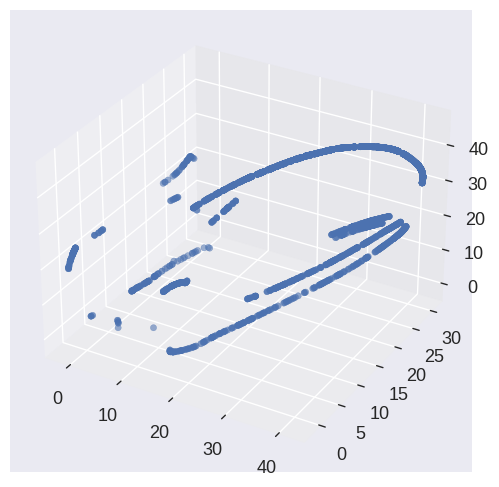

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature_arr[:, 0], feature_arr[:, 1], feature_arr[:, 2])